In [88]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# CONFIGS

In [84]:
# Find total number of ratings instances for top n movies
top_n = 10

# Aggregation Option (concat / outer / outer1)
option = 'outer1'

if option == 'concat':
    d = 48
    EMB_DIM = 24
    
elif option == 'outer':
    d = 551
    EMB_DIM = 50
    
elif option == 'outer1':
    d = 600
    EMB_DIM = 50
    
else:
    print('will be no implemented')

# Hyperparameters for Training
learning_rate = 0.0001
weight_decay  = 0.00001
num_epoch = 250
B = 50 # batchsize

# Additional char tail for save/load
load_tail = ''

___

## USER

In [4]:
user = pd.read_csv("./raw/u.user", header = None, sep = "|")
user.columns = ["user_id","age","gender","occupation","zipcode"]
user = user.drop(["zipcode"], axis = 1)

bins = [0, 20, 30, 40, 50, 60, np.inf]
names = ['<20', '20-29', '30-39','40-49', '51-60', '60+']

user['agegroup'] = pd.cut(user['age'], bins, labels=names)
user = user.drop(["age"], axis = 1)
user.head()

,user_id,gender,occupation,agegroup
0,1,M,technician,20-29
1,2,F,other,51-60
2,3,M,writer,20-29
3,4,M,technician,20-29
4,5,F,other,30-39


In [5]:
columnsToEncode = ["agegroup","gender","occupation"]
myEncoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
myEncoder.fit(user[columnsToEncode])

user_features = pd.concat([user.drop(columnsToEncode, 1),
                           pd.DataFrame(myEncoder.transform(user[columnsToEncode]), 
                                        columns = myEncoder.get_feature_names(columnsToEncode))], axis=1).reindex()
print(user_features.shape)
user_features.head()

(943, 30)


/tmp/ipykernel_11418/3815621287.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  user_features = pd.concat([user.drop(columnsToEncode, 1),
/home/minchan/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,user_id,agegroup_20-29,agegroup_30-39,agegroup_40-49,agegroup_51-60,agegroup_60+,agegroup_<20,gender_F,gender_M,occupation_administrator,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
user_features_array = user_features.to_numpy()

user_id_to_feature = dict(zip(user_features_array[:,0], user_features_array[:,1:]))

In [7]:
user_id_to_feature[2]

array([0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

## Movie

In [8]:
movie = pd.read_csv("./raw/u.item", header = None, sep = "|", encoding='latin-1')
movie.columns = ["movie_id", "movie_title", "release_date", "video_release_date", "IMDb_URL", 
                  "unknown", "Action", "Adventure","Animation","Children's","Comedy","Crime","Documentary","Drama","Fantasy",
                  "Film-Noir","Horror", "Musical", "Mystery","Romance","Sci-Fi","Thriller", "War","Western"]
movie_features = movie.drop(["movie_title","release_date", "video_release_date", "IMDb_URL"],axis = 1)
movie_features.head()

,movie_id,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [9]:
movie_features_array = movie_features.to_numpy()

In [10]:
movie_features.shape

(1682, 20)

## Data

In [53]:
data = pd.read_csv("./raw/u.data", sep ="\t", header=None, names = ["user_id", "movie_id","rating", "timestamp"])
data = data.drop(["timestamp"], axis = 1)

data.groupby("movie_id").count().sort_values("user_id", ascending = False).head(n)["rating"].sum()

4863

In [54]:
# Obtain top movies index
top_movies_index = data.groupby("movie_id").count().sort_values("user_id", ascending = False).head(top_n).reset_index()["movie_id"]
top_movies_features = movie_features[movie_features.movie_id.isin(top_movies_index)]

top_movies_id_dict = dict(zip(top_movies_features['movie_id'],range(top_n)))
top_movies_features = top_movies_features.replace({"movie_id": top_movies_id_dict})
top_movies_index = data.groupby("movie_id").count().sort_values("user_id", ascending = False).head(top_n).reset_index()["movie_id"]

top_movies_features_array = top_movies_features.to_numpy()
top_movies_id_to_feature = dict(zip(top_movies_features_array[:,0], top_movies_features_array[:,1:]))

In [55]:
filtered_data_original = data[data["movie_id"].isin(top_movies_index)]
filtered_data_original = filtered_data_original.replace({"movie_id": top_movies_id_dict})
filtered_data_original.head()

,user_id,movie_id,rating
24,308,0,4
50,251,2,4
53,25,4,5
61,20,7,1
100,32,8,3


In [56]:
filtered_data_original["reward"] = np.where(filtered_data_original["rating"] <5,0,1)
filtered_data_original.pop("rating")
filtered_data_original = filtered_data_original.reset_index(drop = True)

print(filtered_data_original.shape)
filtered_data_original.head()

(4863, 3)


,user_id,movie_id,reward
0,308,0,0
1,251,2,0
2,25,4,1
3,20,7,0
4,32,8,0


In [57]:
#User-wise check
filtered_data = filtered_data_original.reindex(np.random.permutation(filtered_data_original.index)).reset_index(drop = True)

len(set(filtered_data['movie_id'].tolist()))

10

_________________________________

## Train Autoencoder

In [74]:
Y = filtered_data_original['reward'].to_numpy()
Y.shape

(4863,)

In [75]:
class Autoencoder(nn.Module):
    def __init__(self, d=d, emb_dim=EMB_DIM):
        super().__init__()
        self.emb_dim = emb_dim
        self.d = d
        self.encoder = nn.Linear(self.d, self.emb_dim)
        self.decoder = nn.Linear(self.emb_dim, self.d)
                
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(x.shape[0],-1)
        encoded = self.encoder(x)
        out = self.decoder(encoded).view(batch_size, self.d)
        return out
    
    def encoding_result(self, x):
        batch_size = x.shape[0]
        x = x.view(x.shape[0],-1)
        encoded = self.encoder(x)
        return encoded

In [76]:
model = Autoencoder(d=d, emb_dim=EMB_DIM).to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [77]:
L = filtered_data_original.shape[0]

loss_arr = []

for k in tqdm.tqdm(range(num_epoch)):
    
    for l in range(L//B + 1):
        
        user_ids  = filtered_data.iloc[l*B:(l+1)*B, :]['user_id'].to_numpy()
        movie_ids = filtered_data.iloc[l*B:(l+1)*B, :]['movie_id'].to_numpy()
        
        feature = []
        if option == 'concat':
            for user_id, movie_id in zip(user_ids,movie_ids):
                user_feature = user_id_to_feature[user_id]
                movie_feature= top_movies_id_to_feature[movie_id]
                feature.append(np.concatenate((user_feature, movie_feature)))
                
        elif option == 'outer':
            for user_id, movie_id in zip(user_ids,movie_ids):
                user_feature = user_id_to_feature[user_id]
                movie_feature= top_movies_id_to_feature[movie_id]
                feature.append(np.outer(user_feature, movie_feature).flatten())
                
        elif option == 'outer1':
            for user_id, movie_id in zip(user_ids,movie_ids):
                user_feature = user_id_to_feature[user_id]
                movie_feature= top_movies_id_to_feature[movie_id]
                feature.append(np.outer(np.append(user_feature,1), np.append(movie_feature,1)).flatten())
                
        else:
            raise NotImplemented
            
        feature = np.vstack(feature).copy()
        x = torch.from_numpy(feature).type(torch.FloatTensor).to(device)

        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,x)
        loss.backward()
        optimizer.step()

    loss_arr.append(loss.cpu().data.numpy())

100%|██████████| 250/250 [01:15<00:00,  3.31it/s]


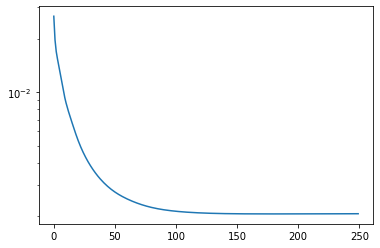

In [78]:
plt.plot(loss_arr)
plt.yscale("log")

In [82]:
model.eval()
with torch.no_grad():
    model.eval()
    print(x[0][:10])
    print(model.encoding_result(x)[0][:10])
    print(model.forward(x)[0][:10])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([ 0.5908, -0.3837,  0.3829, -0.2909,  0.8253,  0.3597, -0.6382,  0.2419,
        -0.2500,  0.6509], device='cuda:0')
tensor([-1.4147e-06,  1.5599e-04,  6.3190e-02,  1.1366e-03,  1.2046e-03,
         7.0675e-03,  3.8333e-02,  1.5314e-05, -8.1432e-03,  1.8841e-05],
       device='cuda:0')


## Save

저장 구조: 

- Autoencoder: user feature와 movie feature concat한 것을 처리
- filtered dataset: pandas dataframe. user_id/movie_id/reward를 담고있다.
- user_id에 대한 one-hot feature의 dictionary.
- selected movie(n개)에 대한 one hot feature를 array로 저장함 (50

In [80]:
# Save Autoencoder
torch.save(model.state_dict(), '../../models/ml100k_autoencoder_{}{}.pt'.format(option,load_tail))

# Save filtered_dataset
filtered_data.to_csv('./preprocess/filtered_data{}.csv'.format(load_tail),index = False)

# Save user_features with dictionary
with open('./preprocess/user_id_to_feature{}.pickle'.format(load_tail), 'wb') as f:
    pickle.dump(user_id_to_feature, f, pickle.HIGHEST_PROTOCOL)

# Save top_movie_features
top_movies_array = (top_movies_features.drop(columns='movie_id')).to_numpy()
np.save('./preprocess/top_movies_array{}'.format(load_tail),top_movies_array)

In [ ]:
print(top_movies_array.shape)

In [ ]:
pd.read_csv('./filtered_data.csv', index_col = 0)